# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [17]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [18]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [19]:
# Your code here:
display(customers.head(5))
customers.info()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [20]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


<function matplotlib.pyplot.show(close=None, block=None)>

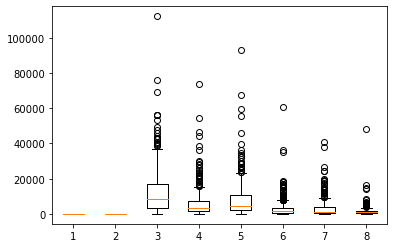

In [21]:
plt.boxplot(customers.values)
plt.show

In [22]:
cc = customers.corr()
cc[(cc > 0.8) & (cc < 1)].any()
# Grocery x Detergents_Paper

Channel             False
Region              False
Fresh               False
Milk                False
Grocery              True
Frozen              False
Detergents_Paper     True
Delicassen          False
dtype: bool

<AxesSubplot:xlabel='Grocery', ylabel='Detergents_Paper'>

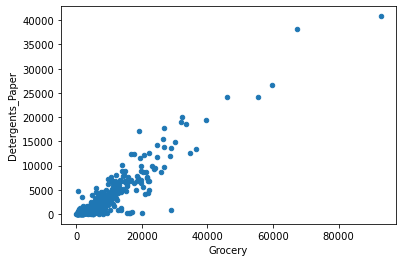

In [23]:
# Your observations here
customers.plot.scatter('Grocery','Detergents_Paper')

<ipython-input-24-b22be0f30322>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(customers.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

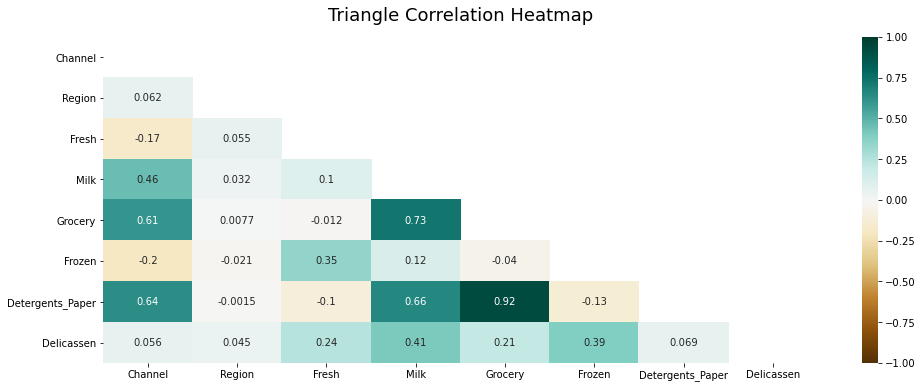

In [24]:
import seaborn as sns

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(customers.corr(), dtype=np.bool))
heatmap = sns.heatmap(customers.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [25]:
# Your code here
categorical_features = ['Channel', 'Region']
continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

for col in categorical_features:
    dummies = pd.get_dummies(customers[col], prefix=col)
    customers = pd.concat([customers, dummies], axis=1)
    customers.drop(col, axis=1, inplace=True)
    
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


<ipython-input-26-b22be0f30322>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(customers.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

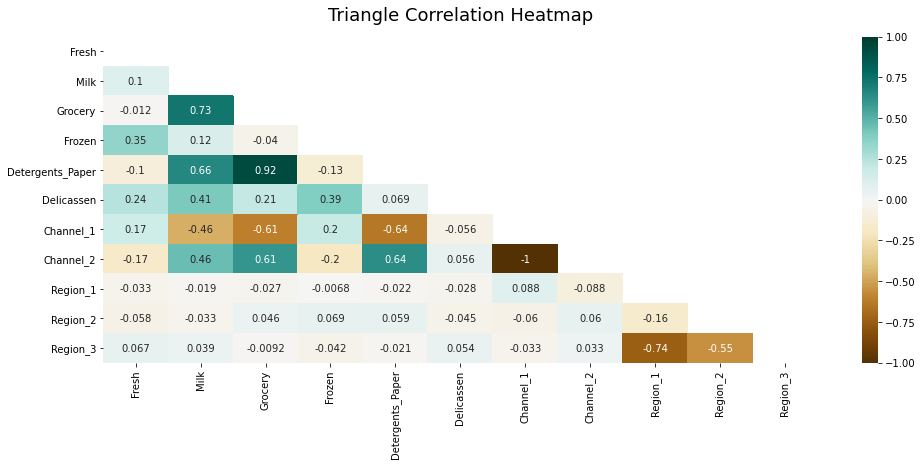

In [26]:
import seaborn as sns

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(customers.corr(), dtype=np.bool))
heatmap = sns.heatmap(customers.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [27]:
# LÇooking at the new coorelation matrix we can see that the Region doesn't afect our features in a considerable way
customers.drop(columns=['Region_1','Region_2','Region_3'], axis=1, inplace=True)
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2
0,12669,9656,7561,214,2674,1338,0,1
1,7057,9810,9568,1762,3293,1776,0,1
2,6353,8808,7684,2405,3516,7844,0,1
3,13265,1196,4221,6404,507,1788,1,0
4,22615,5410,7198,3915,1777,5185,0,1


We needed to do a split of categorical and continuous features.
After we need to transform them in dumies

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [30]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
scaler.fit(customers)
customers_scale = scaler.transform(customers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [31]:
# Your code here:
from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(customers_scale)
customers['labels'] = kmeans.labels_

Count the values in `labels`.

In [32]:
# Your code here:
customers['labels'].value_counts()

0    212
7     98
3     48
1     37
4     35
5      7
6      2
2      1
Name: labels, dtype: int64

In [34]:
from sklearn.metrics import silhouette_score

data = customers.drop(columns=['labels'], axis=1)
target = customers['labels']

score = silhouette_score(data, target, metric='euclidean')
score

0.1959592765758417

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.
0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
-1: Means clusters are assigned in the wrong way.

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [35]:
# Your code here
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.5)
dbscan_model.fit(customers_scale)
customers['labels_DBSCAN'] = dbscan_model.labels_

Count the values in `labels_DBSCAN`.

In [36]:
# Your code here:
customers['labels_DBSCAN'].value_counts()

 1    201
-1    194
 0     32
 3      8
 2      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

In [38]:
target_kmeans = customers['labels']
score_kmeans = silhouette_score(data, target_kmeans, metric='euclidean')
print(score_kmeans)

target_dbscan = customers['labels_DBSCAN']
score_dbscan = silhouette_score(data, target_dbscan, metric='euclidean')
print(score_dbscan)

0.1959592765758417
-0.1313098063387462


Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Detergents_Paper', ylabel='Milk'>

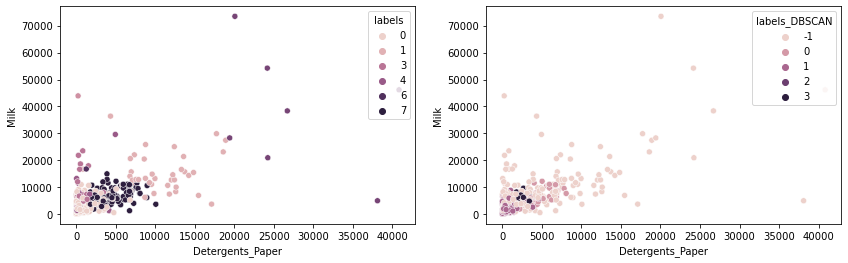

In [39]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], hue=customers['labels'], data=customers, ax=ax[0])
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], hue=customers['labels_DBSCAN'], data=customers, ax=ax[1])

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Grocery', ylabel='Fresh'>

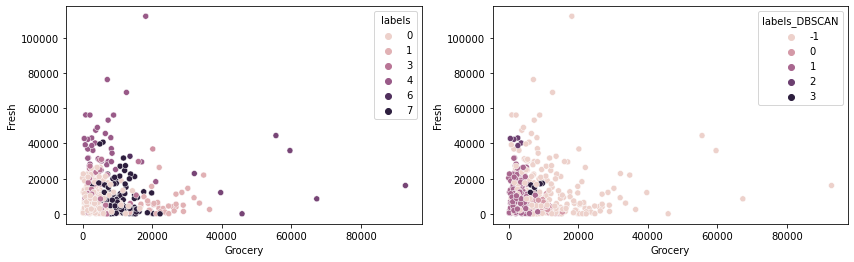

In [40]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Grocery'], customers['Fresh'], hue=customers['labels'], data=customers, ax=ax[0])
sns.scatterplot(customers['Grocery'], customers['Fresh'], hue=customers['labels_DBSCAN'], data=customers, ax=ax[1])

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\msart\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Frozen', ylabel='Delicassen'>

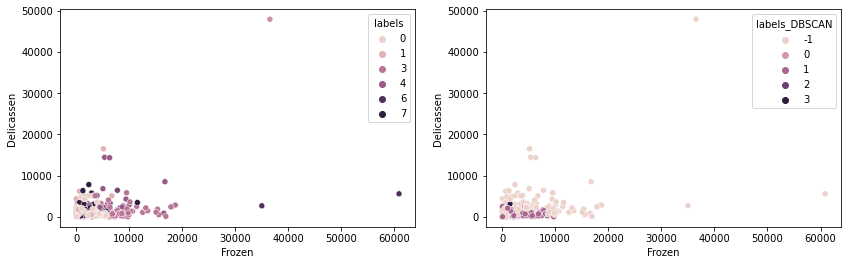

In [41]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Frozen'], customers['Delicassen'], hue=customers['labels'], data=customers, ax=ax[0])
sns.scatterplot(customers['Frozen'], customers['Delicassen'], hue=customers['labels_DBSCAN'], data=customers, ax=ax[1])

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [42]:
# Your code here:
customers.groupby(['labels','labels_DBSCAN']).mean()

Fresh          Milk       Grocery        Frozen  \
labels labels_DBSCAN                                                           
0      -1              8334.294118   5354.235294   7427.264706   1476.147059   
        1              8802.162921   2128.320225   2701.500000   1715.589888   
1      -1              5877.621622  15572.270270  23743.054054   1726.054054   
2      -1             36847.000000  43950.000000  20170.000000  36534.000000   
3      -1             13959.068966   7161.137931   5217.793103  10601.965517   
        1             12048.263158   2081.473684   2623.000000   7442.789474   
4      -1             43258.192308   5587.038462   7393.653846   6284.307692   
        1             29753.000000   1078.750000   1809.750000   2589.750000   
        2             41446.600000   1421.200000   2167.600000   1276.400000   
5      -1             20031.285714  38084.000000  56126.142857   2564.571429   
6      -1             22015.500000   9937.000000   7844.000000  47939.000000   
7      -1             10932.379310   7125.258621  11406.396552   2069.948276   
        0              4838.500000   6644.593750  10277.156250    784.593750   
        3             14726.625000   6636.125000   7003.625000    961.375000   

                      Detergents_Paper    Delicassen  Channel_1  Channel_2  
labels labels_DBSCAN                                                        
0      -1                  2218.588235   1848.235294        1.0        0.0  
        1                   564.808989    747.011236        1.0        0.0  
1      -1                 10845.702703   2174.378378        0.0        1.0  
2      -1                   239.000000  47943.000000        1.0        0.0  
3      -1                   698.206897   1951.965517        1.0        0.0  
        1                   389.315789    913.052632        1.0        0.0  
4      -1                  1049.346154   3398.461538        1.0        0.0  
        1                   257.000000    914.500000        1.0        0.0  
        2                   416.200000    784.800000        1.0        0.0  
5      -1                 27644.571429   2548.142857        0.0        1.0  
6      -1                   671.500000   4153.500000        1.0        0.0  
7      -1                  4551.086207   1774.637931        0.0        1.0  
        0                  4776.093750   1004.843750        0.0        1.0  
        3                  2583.625000   1951.875000        0.0        1.0

In [43]:
customers.groupby('labels').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,labels_DBSCAN
labels,,,,,,,,,
0,8727.127358,2645.683962,3459.405660,1677.188679,830.037736,923.622642,1.0,0.0,0.679245
1,5877.621622,15572.270270,23743.054054,1726.054054,10845.702703,2174.378378,0.0,1.0,-1.000000
2,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,1.0,0.0,-1.000000
3,13202.708333,5150.437500,4190.687500,9351.458333,575.937500,1540.729167,1.0,0.0,-0.208333
4,41455.942857,4476.685714,6008.914286,5146.657143,868.342857,2741.200000,1.0,0.0,-0.342857
5,20031.285714,38084.000000,56126.142857,2564.571429,27644.571429,2548.142857,0.0,1.0,-1.000000
6,22015.500000,9937.000000,7844.000000,47939.000000,671.500000,4153.500000,1.0,0.0,-1.000000
7,9252.275510,6928.377551,10678.255102,1559.744898,4463.948980,1537.744898,0.0,1.0,-0.346939


In [44]:
customers.groupby('labels_DBSCAN').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,labels
labels_DBSCAN,,,,,,,,,
-1,14873.912371,9560.984536,13221.046392,4408.881443,5068.613402,2398.324742,0.474227,0.525773,3.520619
0,4838.500000,6644.593750,10277.156250,784.593750,4776.093750,1004.843750,0.000000,1.000000,7.000000
1,9525.940299,2103.004975,2676.333333,2274.363184,542.094527,766.039801,1.000000,0.000000,0.363184
2,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,1.000000,0.000000,4.000000
3,14726.625000,6636.125000,7003.625000,961.375000,2583.625000,1951.875000,0.000000,1.000000,7.000000


Which algorithm appears to perform better?

Lookign at our groupby tables, we can see that K-means has an overfitting considering the channels.
While DBSCAN has a more dispersed means between the pair feature-label

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

C:\Users\msart\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


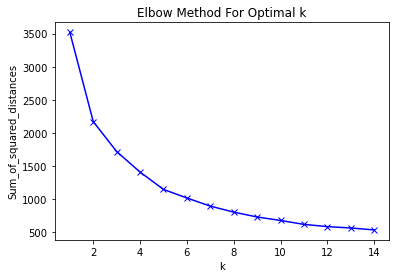

In [45]:
# For each k value, we will initialise k-means and use the inertia attribute
# to identify the sum of squared distances of samples to the nearest cluster centre.

Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(customers_scale)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the plot above the elbow (if the plot looks like an arm, then the elbow on the arm is optimal k.) is at k=5 indicating the optimal k for this dataset is 5

In [46]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(customers_scale)
customers['labels'] = kmeans.labels_

data = customers.drop(columns=['labels'], axis=1)
target = customers['labels']

score = silhouette_score(data, target, metric='euclidean')
score

0.2573816376440367

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

epsfloat, default=0.5
The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

min_samplesint, default=5
The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

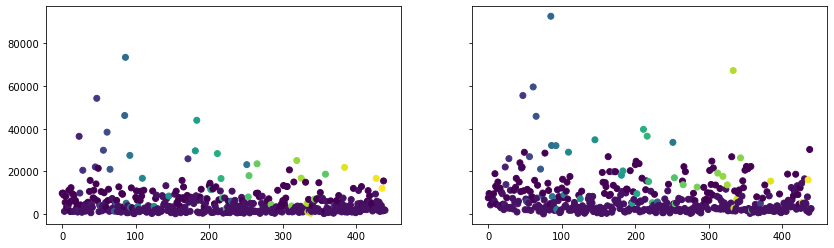

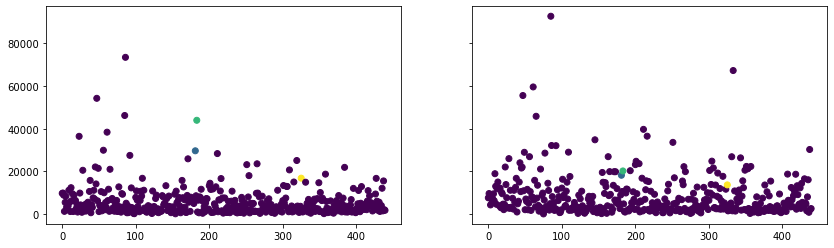

In [47]:
# Changing just eps
DBSCAN_exp = DBSCAN(eps=1, min_samples=1)
preds = DBSCAN_exp.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

######################################################
DBSCAN_exp = DBSCAN(eps=5, min_samples=1)
preds = DBSCAN_exp.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

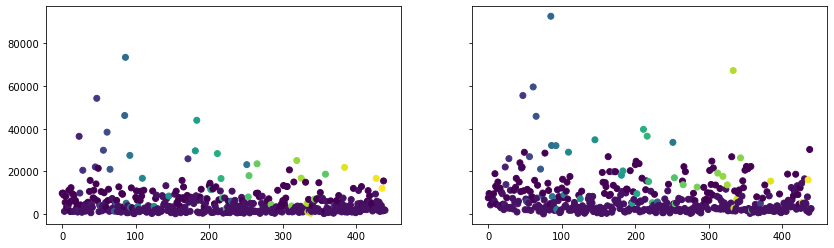

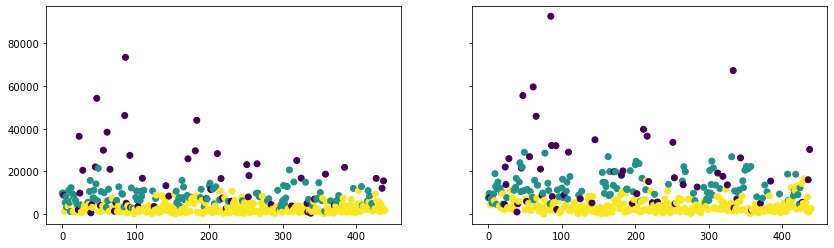

In [48]:
# Changing just min_samples
DBSCAN_exp = DBSCAN(eps=1, min_samples=1)
preds = DBSCAN_exp.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

######################################################
DBSCAN_exp = DBSCAN(eps=1, min_samples=5)
preds = DBSCAN_exp.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

I tried to follow this tutorial to find the best eps, but I don't think I made it correctly:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

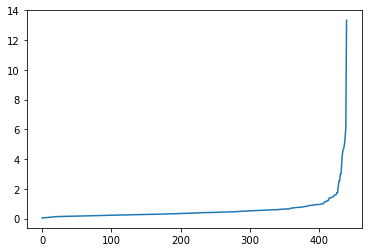

In [49]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns

# We can calculate the distance from each point to its closest neighbour using the NearestNeighbors.
# The point itself is included in n_neighbors. The kneighbors method returns two arrays,
# one which contains the distance to the closest n_neighbors points and the other which
# contains the index for each of those points.

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(customers_scale)
distances, indices = nbrs.kneighbors(customers_scale)

# Next, we sort and plot results.
# The optimal value for epsilon will be found at the point of maximum curvature.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

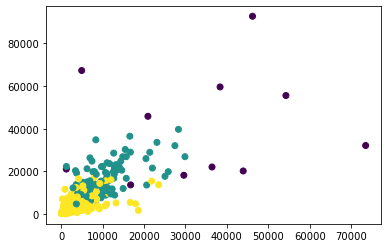

In [50]:
# We train our model, selecting 2 for eps and setting min_samples to 5.
m = DBSCAN(eps=2)
m.fit(customers_scale)

clusters = m.labels_
plt.scatter(customers['Milk'], customers['Grocery'], c=clusters)

In [53]:
customers['labels_DBSCAN'] = clusters

target_dbscan = customers['labels_DBSCAN']
score_dbscan = silhouette_score(data, target_dbscan, metric='euclidean')
print(score_dbscan)

0.22252956116228478


SOOOOOOOOO

After all of this, we maneged to achieve a silhouette_score for K-menas of 0.2574, that is still bigger than DBSACN with 0.2225.
Meaning that our K-menas model stil separetes our classes more distinctly.